### From this notebook, you can  quickly visualize and gather insights on data
- [Retrieve the data from Postgres Server Side](#1.--Import-Dataset)
- [Check Null values and reset the data type](#2.-Pandas-DataFrame)
- [Number of courses by category](#The-number-of-courses-by-category)
- [The top 15 popular languages used in Udemy](#The-top-15-popular-languages-used-in-Udemy)
- [Distribution of average course rating by category](#The-number-of-subscribers-for-courses-by-category)
- [Distribution of number of subscribers by category](#Distribution-of-number-of-subscribers-by-category)
- [Distribution of course length by category](#The-distribution-of--length-of-course-by-category)
- [Relationship among course length, number of subscribers and average course rating](#Relationship-among-course-length,-number-of-subscribers-and-average-course-rating)

In [1]:
import psycopg2 as pg2
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import seaborn as sns
import matplotlib.pyplot as plt
from googletrans import Translator
import numpy as np
from IPython.display import Image, display, HTML

## 1.  Import Dataset

The dataset is stored in Postgres server on AWS instance. The variables `DBNAME`,`IP_ADDRESS`,`dbname`, and `PASSWORD` are assigned after run the `sql_tabl.py` file.  We can retrieve the data using `psycopg2` library to connect to the server side. The function `con_cur_to_db` and `execute_query`  allow us to access the database and type the SQL query in the Postgres, and quite the database after commit the query.  

In [2]:
%run ../sql_table.py

In [3]:
def con_cur_to_db(dbname=DBNAME, dict_cur=None):
    ''' 
    Returns both a connection and a cursor object for your database
    '''
    con = pg2.connect(host=IP_ADDRESS,
                  dbname=dbname,
                  user=USER,
                  password=PASSWORD)
    if dict_cur:
        cur = con.cursor(cursor_factory=RealDictCursor)
    else:
        cur = con.cursor()
    
    return con, cur

In [4]:
def execute_query(query, dbname=DBNAME, dict_cur=None, command=False):
    '''
    Executes a query directly to a database, without having to create a cursor and connection each time. 
    '''
    con, cur = con_cur_to_db(dbname, dict_cur)
    cur.execute(f'{query}')
    if not command:
        data = cur.fetchall()
        col_names = []
        for elt in cur.description:
            col_names.append(elt[0])
        con.close()
        return data, col_names
    con.commit()
    con.close()

In [5]:
query = '''
SELECT *
FROM udemy
'''
data, column_names = execute_query(query)

## 2. Pandas DataFrame 

In [6]:
df = pd.DataFrame(data, columns=column_names)

### Missing Values
The dataset has 12 columns and 79821 rows, and there are missing values in `headline` and `description` columns. The missing data can be will with text "No_content" instead of dropping them. 

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79821 entries, 0 to 79820
Data columns (total 12 columns):
id                    79821 non-null int64
avg_rating_recent     79821 non-null object
objectives_summary    79821 non-null object
num_subscribers       79821 non-null object
content_info          79821 non-null object
headline              79773 non-null object
image_304x171         79821 non-null object
title                 79821 non-null object
url                   79821 non-null object
language              79821 non-null object
category              79821 non-null object
description           79793 non-null object
dtypes: int64(1), object(11)
memory usage: 7.3+ MB


In [8]:
df.isnull().sum()

id                     0
avg_rating_recent      0
objectives_summary     0
num_subscribers        0
content_info           0
headline              48
image_304x171          0
title                  0
url                    0
language               0
category               0
description           28
dtype: int64

In [9]:
df.fillna('No_content', inplace=True)

### Reset the datatype
The data type of `num_subscribers` and `avg_rating_recent` should not be object but integer and float numeric values.

In [10]:
df['num_subscribers'] = df['num_subscribers'].astype('int64')
df['avg_rating_recent'] = df['avg_rating_recent'].astype('float64')

### Set the style of axes and text color for plots

In [11]:
plt.rcParams['axes.edgecolor']='#333F4B'
plt.rcParams['axes.linewidth']=0.8
plt.rcParams['xtick.color']='#333F4B'
plt.rcParams['ytick.color']='#333F4B'
plt.rcParams['text.color']='#333F4B'

## 3. EDA

In this section, we want to investigate how many courses are assigned in each categories and 
the distribution of the numeric variables by course category.


### Create a `barplot` function

In [12]:
def bar_plot(data, text, data_index):
    fig, ax = plt.subplots(figsize=(10,6))
    my_range = data_index
    plt.hlines(y=my_range, xmin=0, xmax=data.values, color='#3F5D7D', alpha=0.4, linewidth=12)
    plt.plot(data.values, my_range, "o", markersize=10, color='#3F5D7D', alpha=1)

    ax.set_xlabel('Number of Courses', fontsize=15, fontweight='black', color = '#333F4B')
    ax.set_ylabel('')

    ax.tick_params(axis='both', which='major', labelsize=12)
    plt.yticks(my_range, data_index, fontsize=25)

    fig.text(-0.10, 0.90, text, fontsize=15, fontweight='black', color = '#333F4B')

    # change the style of the axis spines
    ax.spines['top'].set_color('none')
    ax.spines['right'].set_color('none')
    ax.spines['left'].set_smart_bounds(True)
    ax.spines['bottom'].set_smart_bounds(True)

    # set the spines position
    ax.spines['bottom'].set_position(('axes', -0.04))
    ax.spines['left'].set_position(('axes', 0.015))
    

### The number of courses by category

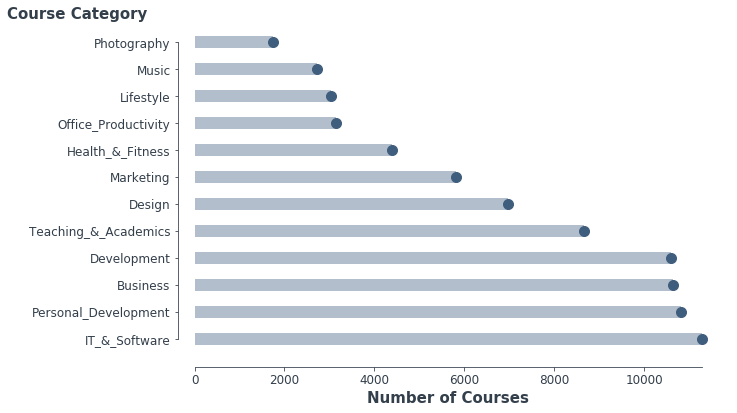

In [13]:
bar_plot(df['category'].value_counts(), 'Course Category', df['category'].value_counts().index )

The barplot shows that categories of IT & Software, Personal_Development, Business, and Development have over 10000 courses. The IT & Software category has the most number of courses and the Photography category has the lease number of courses.

In [14]:
course_lan = df['language'].value_counts()[df['language'].value_counts()>200][:15]
translator = Translator()
language = [translator.translate(i).text for i in course_lan.index]

The course languages are written in foreign letters, the Google translator is used in here to translate the foreign languages to English for interpretability.

### The top 15 popular languages used in Udemy

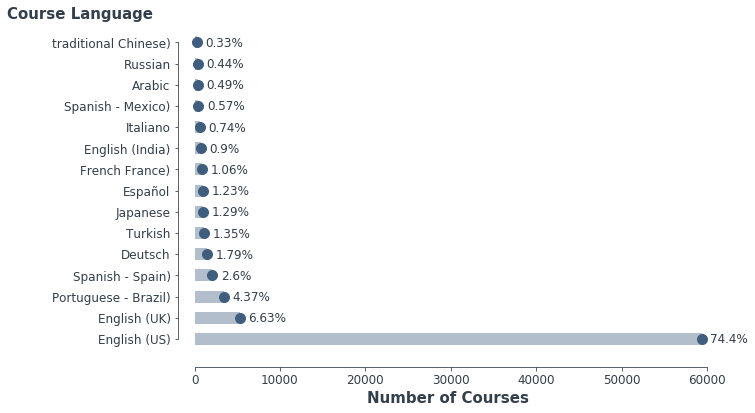

In [15]:
bar_plot(course_lan, 'Course Language', language )
for y, x in enumerate(course_lan):
    plt.annotate(str(round(x/df.shape[0]*100,2))+'%', xy=(x+1000, y-0.2), size=12)

- Considering the Udemy is a worldwide popular MOOC platform, many course instructors at Udemy speak different languages for teaching. We picked the most popular 15 languages that course instructors speak. Unsurprisingly, 74.4% + 6.63% = 81.03% of the courses are taught in English. The third popular language is Portuguese. Other popular languages are including Spanish, Deutsch, Turkish, Japanese, French, Arabic, Russian and Chinese. 

### Create a `subplot_histograms` function

In [16]:
def subplot_histograms(dataframe, column_name, value_col, list_of_categories, list_of_titles):
    nrows = int(np.ceil(len(list_of_categories)/2)) # Makes sure you have enough row
    fig, ax = plt.subplots(nrows=nrows, ncols=2, figsize=(15,5*nrows)) # You'll want to specify your figsize
    ax = ax.ravel() # Ravel turns a matrix into a vector, which is easier to iterate
    if len(list_of_categories) %2 !=0:
        ax[len(list_of_categories)].set_visible(False)
    for i, j in enumerate(list_of_categories): # Gives us an index value to get into all our lists
        ax[i].hist(dataframe[dataframe[column_name]==j][value_col],bins=30,color="#3F5D7D") # feel free to add more settings
        # Set titles, labels, etc here for each subplot
        ax[i].set_title(f' Distribution of {value_col} at\n {list_of_titles[i]} courses', fontsize =18)
        ax[i].set_xlabel(f'{value_col}',fontsize=15)
        ax[i].set_ylabel('Number of courses',fontsize=15);
        ax[i].spines["top"].set_visible(False)  
        ax[i].spines["right"].set_visible(False) 
    plt.tight_layout()

### The number of subscribers for courses by category
We are only interested in the courses that has at least 200 people enrolled.

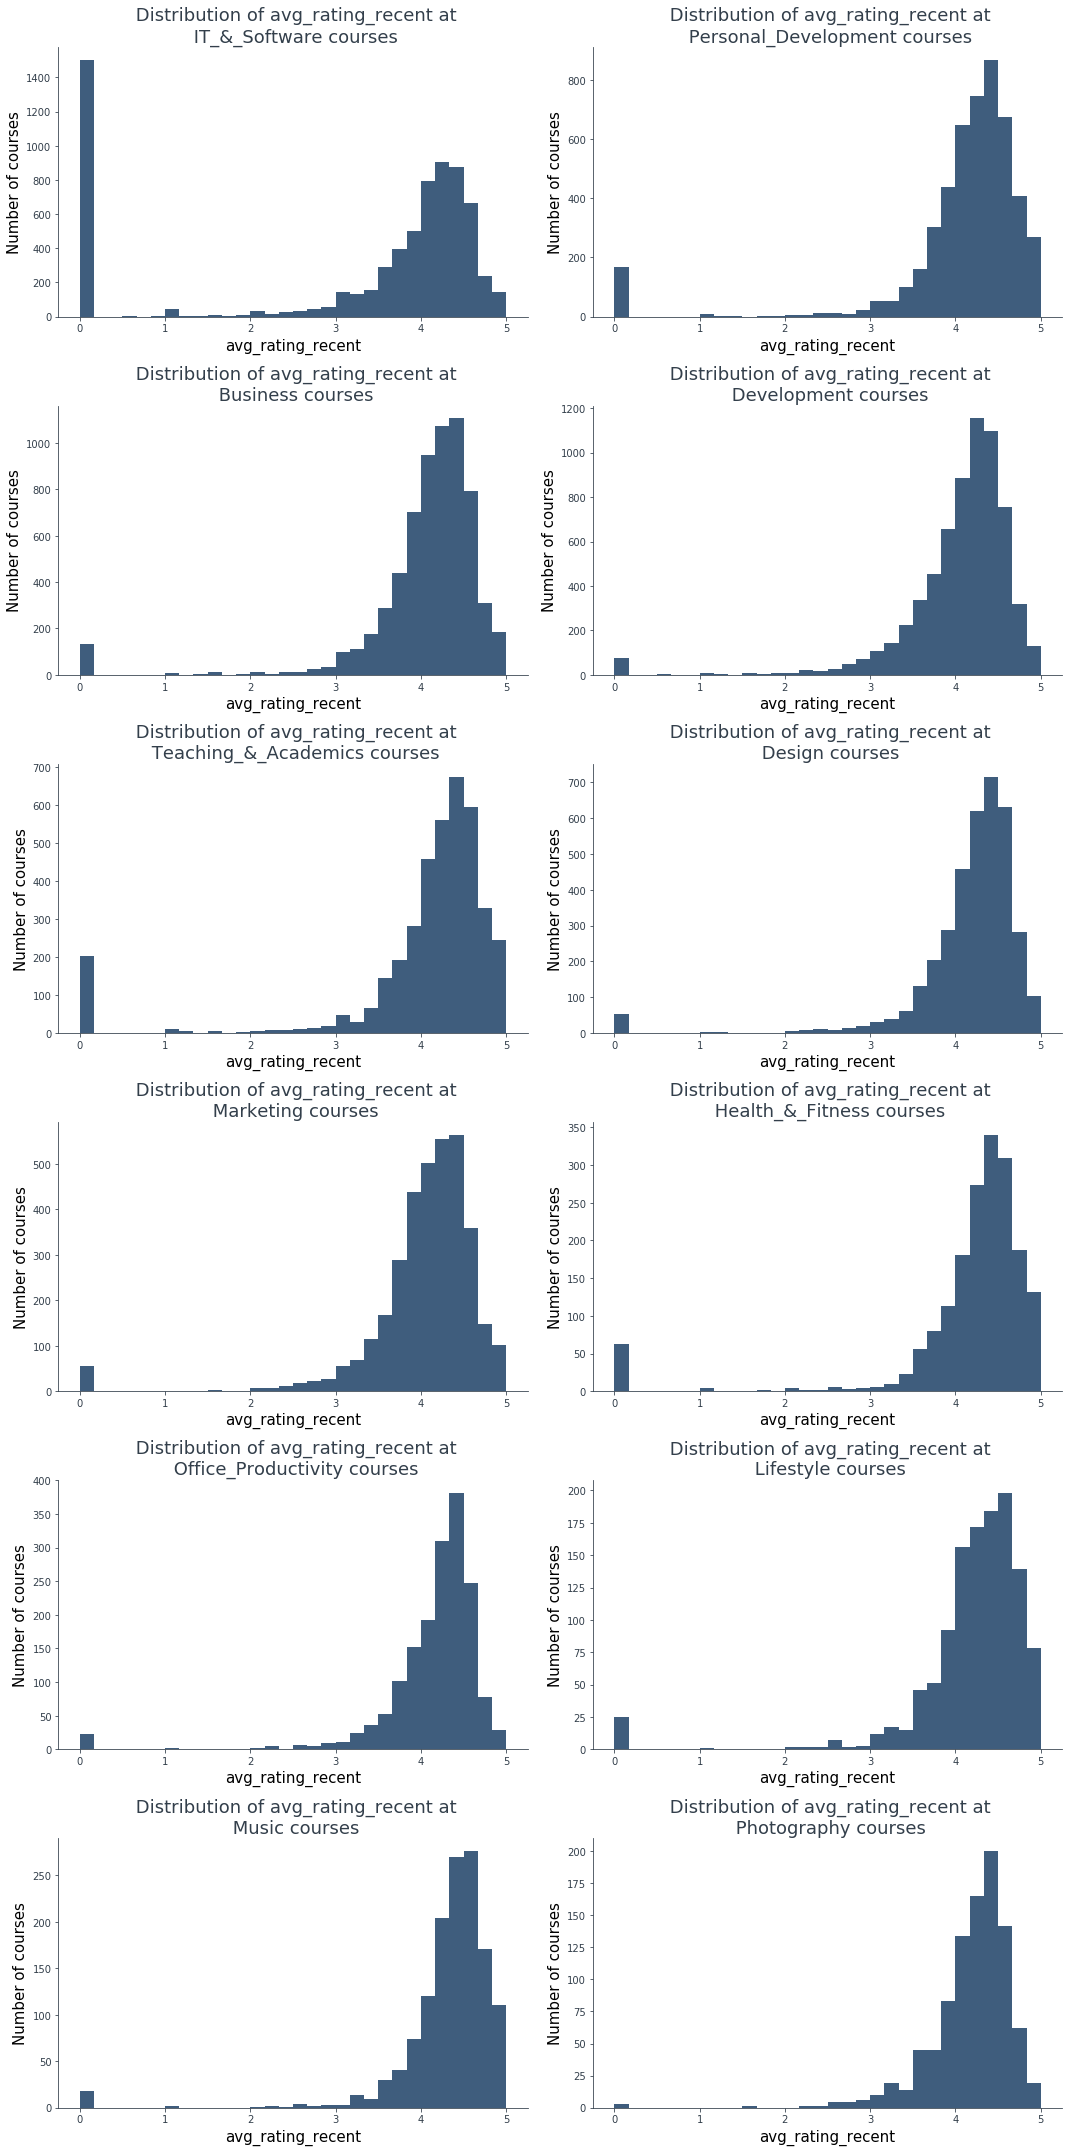

In [17]:
df_num = df[df['num_subscribers']>200]
cat_names = df['category'].value_counts().keys()
subplot_histograms(df_num, 'category', 'avg_rating_recent', cat_names, cat_names)

- The distribution of average rating by category shows that even though there are many courses in IT and Software category, most of them are unrated. In contrast, the courses in the development courses are rated relatively high compare with other categories which have more than 10000 subscribers. 

### Create a `subplot_boxplot` function

In [18]:
def subplot_boxplot(dataframe, column_name, value_col, list_of_categories, list_of_titles):
    nrows = int(np.ceil(len(list_of_categories)/2)) # Makes sure you have enough row
    fig, ax = plt.subplots(nrows=nrows, ncols=2, figsize=(15,5*nrows)) # You'll want to specify your figsize
    ax = ax.ravel() # Ravel turns a matrix into a vector, which is easier to iterate
    if len(list_of_categories) %2 !=0:
        ax[len(list_of_categories)].set_visible(False)
    for i, j in enumerate(list_of_categories): # Gives us an index value to get into all our lists
        ax[i].boxplot(dataframe[dataframe[column_name]==j][value_col]) # feel free to add more settings
        # Set titles, labels, etc here for each subplot
        ax[i].set_title(f' Distribution of {value_col} at\n {list_of_titles[i]} courses', fontsize =18)
        ax[i].set_ylabel('Number of subscribers',fontsize=15);
        ax[i].set_yscale('log')
        ax[i].spines["top"].set_visible(False)  
        ax[i].spines["right"].set_visible(False) 
    plt.tight_layout()

### Distribution of number of subscribers by category

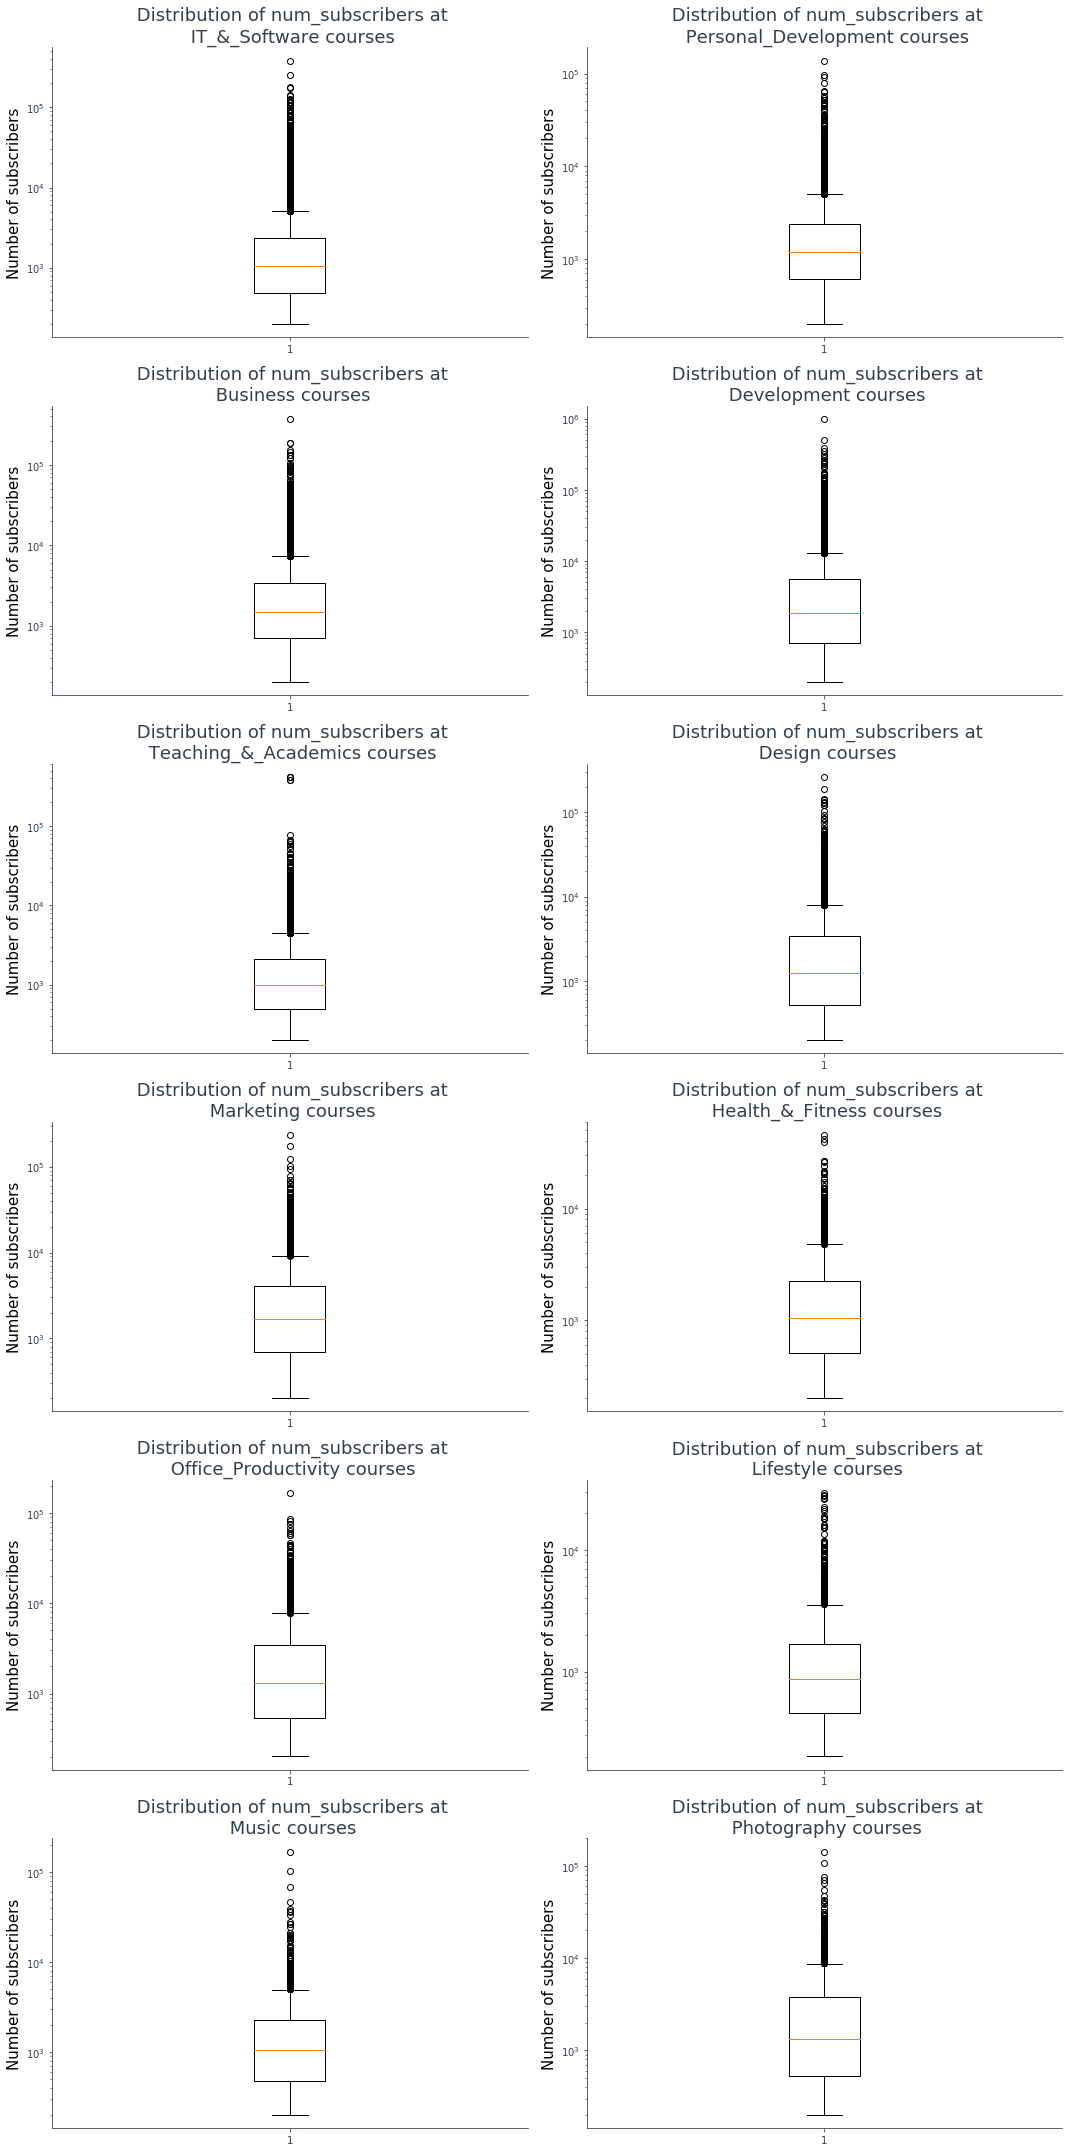

In [19]:
subplot_boxplot(df_num, 'category', 'num_subscribers', cat_names, cat_names)

- Courses in the Development category has the most number of subscribers.

### The distribution of  length of course by category 
We wanted to convert the string in content_info to numeric numbers as a unit of hour. For example, "30 mins" to number 0.5.

In [20]:
hours = []
for i in df['content_info']:
    try:
        if i.split(' ')[1] == 'mins':
            hours.append(round(float(i.split(' ')[0])/60, 2))
        elif i.split(' ')[1] == 'hours':
            hours.append(round(float(i.split(' ')[0]), 2))
        elif i.split(' ')[1] == 'questions':
            hours.append(0)
        else:
            hours.append(0)
    except IndexError:
        hours.append(0)          

df['course_hours'] = hours

df_hours = df[df['course_hours']>0]

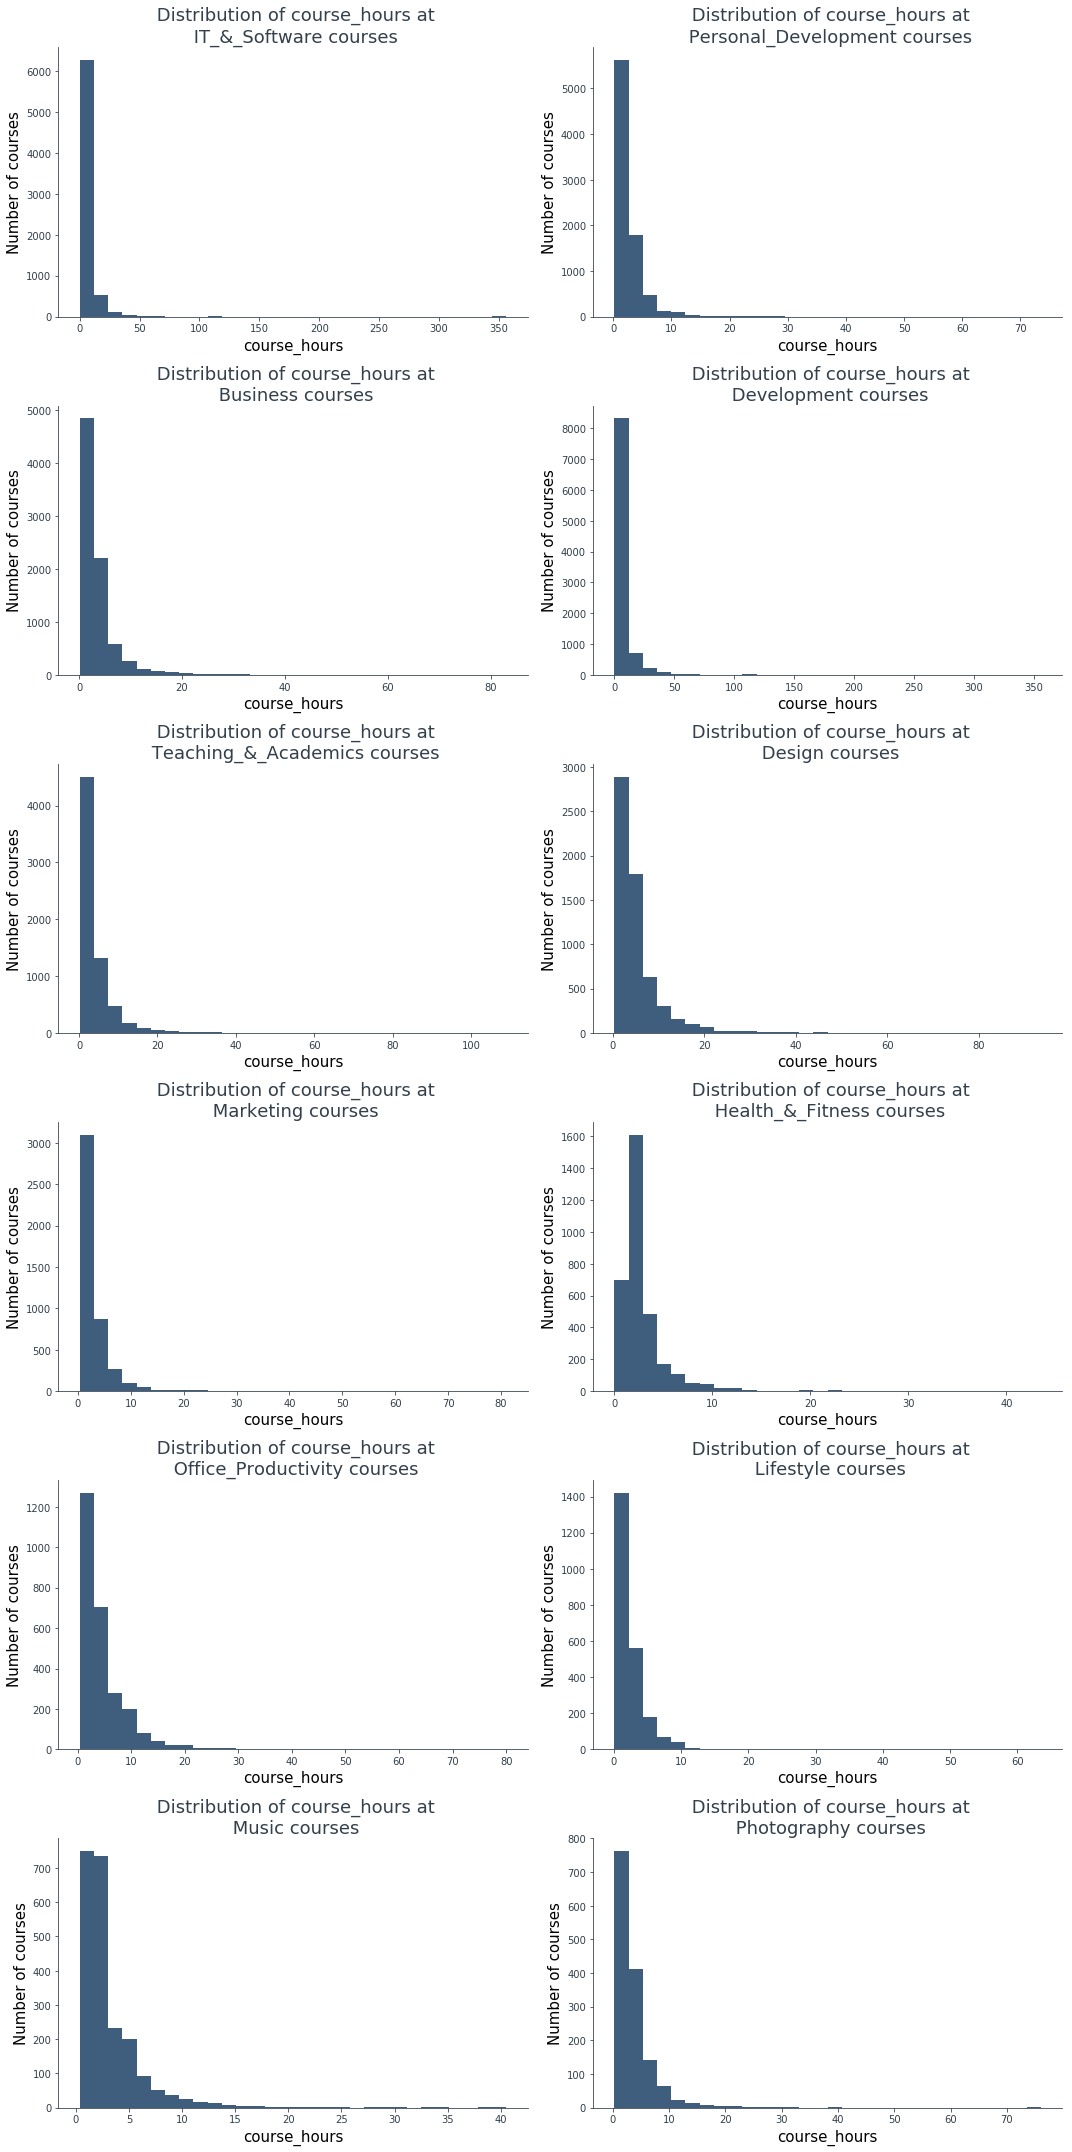

In [21]:
subplot_histograms(df_hours, 'category', 'course_hours', cat_names, cat_names)

- Most courses are in a range from 0 to 25 hours, the courses in the Development category are relatively long which is range from 0 to 50 hours. Surprisingly, there are some courses over 100 hrs.  

Here are courses that contains more than 120 hours content in the development categories.

In [22]:
long_courses = df[(df['course_hours']>120) & (df['category'] == 'Development')]

### Create  a function `show_html`  that used for better visualizing the dataset

In [23]:
def show_html(dataframe, title):
    display(HTML('<html>\
                  <style>\
                         h3 {color:black;}\
                  </style><head>' + '<h3>' + title +'</h3></head></html>'))
    for i in dataframe.index:
        udemy_url = 'https://udemy.com' + dataframe.loc[i]['url']
        display(HTML('<table width="750"><tr>\
                     <td>'\
                     "<img src ="
                     + dataframe.loc[i]['image_304x171'] + ' height="200" width="200"></td>'\
                     +  "<td>"
                     + "<strong>" + dataframe.loc[i]['title'] + "<br>" + "<br>"
                     + "Number of subscribers: "
                     + "</strong>"+ str(dataframe.loc[i]['num_subscribers']) + "<br>" + "<br>"
                     + "<strong>" + "Course duration: "
                     + "</strong>"+ str(dataframe.loc[i]['content_info']) + "<br>" + "<br>"
                     + "<strong>" + "Ratings: "
                     + "</strong>"+ str(dataframe.loc[i]['avg_rating_recent']) + "<br>" + "<br>"
                     + '<button onclick=\"window.location.href ='+ "'" + udemy_url +"'" + ';\">Go to the Website</button>'
                     +  "</td></tr></table>"))

In [24]:
show_html(long_courses,'The Development courses that have longest contents')

,The Complete Android P + Java Developer Course™ : 2019Number of subscribers: 24399Course duration: 135 hoursRatings: 4.31464Go to the Website


,"The Complete Unity® Masterclass: Build 2D, 3D, and VR GamesNumber of subscribers: 4291Course duration: 121 hoursRatings: 4.4126Go to the Website"


,Modern Freelancing Website In PHP&MYSQLI With Bootstrap 4Number of subscribers: 568Course duration: 122 hoursRatings: 4.83806Go to the Website


,Build Your Professional Portfolio: Learn iOS 10 and AndroidNumber of subscribers: 287Course duration: 130 hoursRatings: 4.365469999999999Go to the Website


,The Last Complete Coding Course You Will Ever Need!Number of subscribers: 505Course duration: 356 hoursRatings: 4.46Go to the Website


,Learn to Build some Shooter games with Unity® and Blender!Number of subscribers: 99Course duration: 123.5 hoursRatings: 4.0845199999999995Go to the Website


### Create a function `subplot_scatter`

In [25]:
def subplot_scatter(dataframe, x, y):
    nrows = int(np.ceil(len(x)/2)) # Makes sure you have enough row
    fig, ax = plt.subplots(nrows=nrows, ncols=2, figsize=(15,5*nrows)) # You'll want to specify your figsize
    ax = ax.ravel() # Ravel turns a matrix into a vector, which is easier to iterate
    if len(x) %2 !=0:
        ax[len(x)].set_visible(False)
    for i in range(len(x)): # Gives us an index value to get into all our lists
        sns.scatterplot(dataframe[x[i]],dataframe[y[i]],ax = ax[i],color="#3F5D7D") # feel free to add more settings
        # Set titles, labels, etc here for each subplot
        ax[i].set_title(x[i] +' vs ' + y[i], fontsize =18)
        ax[i].set_ylabel(y[i],fontsize=15)
        ax[i].set_xlabel(x[i],fontsize=15);
        ax[i].spines["top"].set_visible(False)  
        ax[i].spines["right"].set_visible(False)  
    plt.tight_layout()

### Relationship among course length, number of subscribers and average course rating

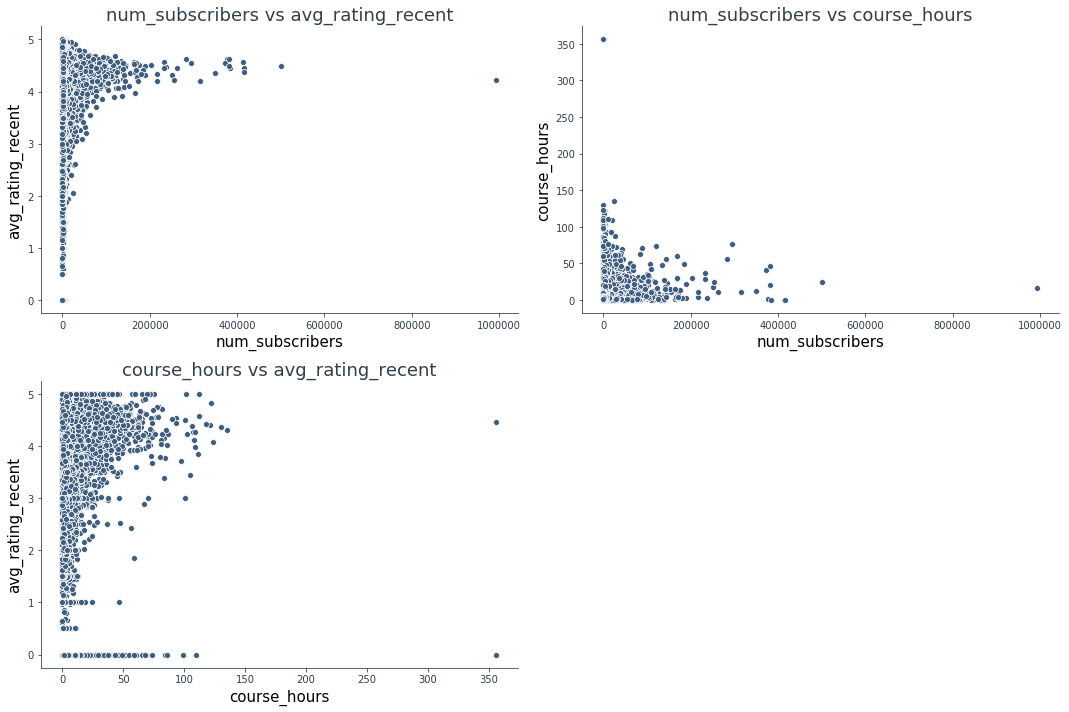

In [26]:
subplot_scatter(df, 
                ['num_subscribers','num_subscribers','course_hours'], 
                ['avg_rating_recent','course_hours','avg_rating_recent'])

- There's no clear linear relationship among course hours, number of subscribers and ratings. 

## 4. Key findings from the EDA
- Categories of IT & Software, Personal_Development, Business, and Development have over 10000 courses. The IT & Software category has the most number of courses and the Photography category has the lease number of courses.
- 81.03% of the courses are taught in English. The third popular language is Portuguese. Other popular languages are including Spanish, Deutsch, Turkish, Japanese, French, Arabic, Russian and Chinese. 
- Despite of many courses in IT and Software category, most of them are unrated. In contrast, the courses in the development courses are rated relatively high compare with other categories which have more than 10000 subscribers. 
- Courses in the Development category has the most number of subscribers.
- Most courses are in a range from 0 to 25 hours, the courses in the Development category are relatively long which is range from 0 to 50 hours. Surprisingly, there are some courses over 100 hrs.
- There's no clear linear relationship among course hours, number of subscribers and ratings.